### Basic QC for non-human primate samples (Gideon)

#### Objective: Run basic QC for week 10 BAL samples in non-human primates from Gideon et al 2021

- **Developed by**: Mairi McClean
- **Affiliation**: Institute of Computational Biology, Computational Health Centre, Helmholtz Munich
- **v221209**

## Load modules

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import igraph as ig
from matplotlib import colors
from matplotlib import rcParams

In [2]:
%matplotlib inline

sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.9.1
scanpy      1.9.3
-----
CoreFoundation      NA
Foundation          NA
PIL                 9.5.0
PyObjCTools         NA
anyio               NA
appnope             0.1.3
asttokens           NA
attr                23.1.0
babel               2.12.1
backcall            0.2.0
certifi             2023.05.07
cffi                1.15.1
charset_normalizer  3.1.0
cloudpickle         2.2.1
colorama            0.4.6
comm                0.1.3
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2023.5.1
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
executing           1.2.0
fastjsonschema      NA
h5py                3.8.0
idna                3.4
igraph              0.10.4
importlib_resources NA
ipykernel           6.23.1
jedi                0.18.2
jinja2              3.1.2
joblib              1.2.0
json5               NA
jsonschema          4.17.3
jupyter_events      0.6.3
ju

### Read in datasets

- Week 4 data

In [6]:
adata = sc.read_10x_mtx('/Volumes/Expansion/data_lake/INBOX/tb_cc/raw_data_objects/single_cell/nhp/gideon2021/week4/')
adata

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


AnnData object with n_obs × n_vars = 10006 × 24820
    var: 'gene_ids'

- Fix .var objects

In [7]:
adata.var

,gene_ids
A2ML1,A2ML1
A3GALT2,A3GALT2
A4GALT,A4GALT
AAAS,AAAS
AACS,AACS
...,...
ZYG11A,ZYG11A
ZYG11B,ZYG11B
ZYX,ZYX
ZZEF1,ZZEF1


In [8]:
adata.var.rename(columns={'gene_ids': 'gene_name'}, inplace=True)
adata.var


,gene_name
A2ML1,A2ML1
A3GALT2,A3GALT2
A4GALT,A4GALT
AAAS,AAAS
AACS,AACS
...,...
ZYG11A,ZYG11A
ZYG11B,ZYG11B
ZYX,ZYX
ZZEF1,ZZEF1


In [9]:
adata.var = adata.var.drop('gene_name', axis=1)

In [10]:
adata.var

""
A2ML1
A3GALT2
A4GALT
AAAS
AACS
...
ZYG11A
ZYG11B
ZYX
ZZEF1


- Make names unique 

In [11]:
adata.var_names_make_unique()
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 10006 × 24820

In [12]:
# Make sure that all names are unique in new data object. 

# Turns var names into string - always required?
sample_object.var_names = [str(i) for i in sample_object.var_names]
sample_object.var_names_make_unique()

### Top 20 scatterplot

normalizing counts per cell
    finished (0:00:00)


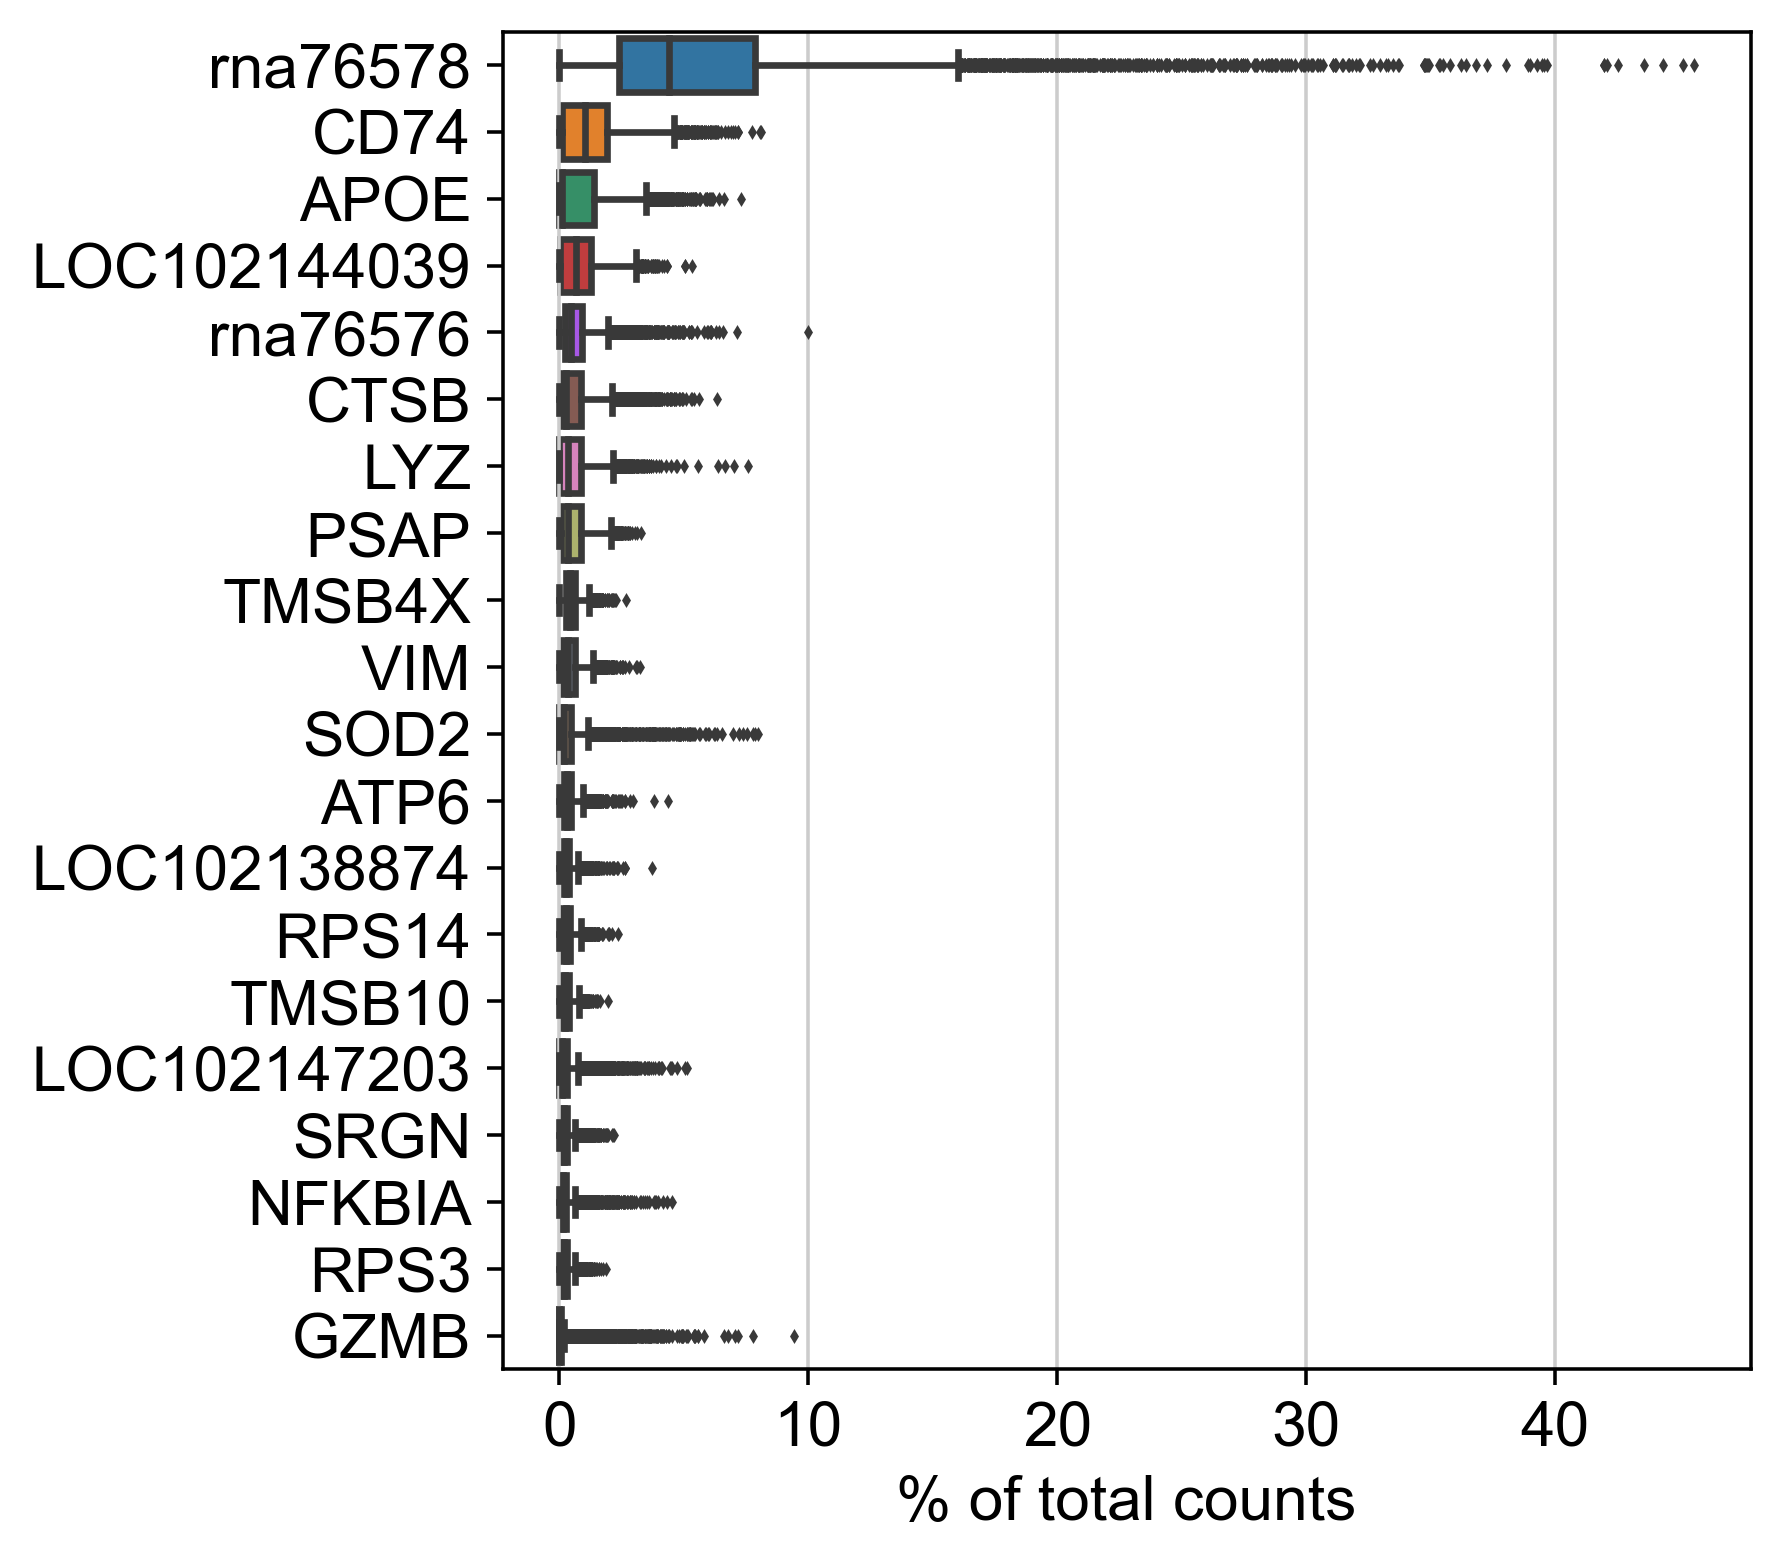

In [13]:
sc.pl.highest_expr_genes(sample_object, n_top=20)

### Inital filtering

- By gene number

In [14]:
sc.pp.filter_cells(sample_object, min_genes = 200)
print(sample_object.n_obs, sample_object.n_vars)

10006 24820


- By cell number 

In [15]:
sc.pp.filter_genes(sample_object, min_cells = 3)
sample_object.shape

filtered out 4878 genes that are detected in less than 3 cells


(10006, 19942)

### QC metrics

In [16]:
sample_object.var['mt'] = sample_object.var_names.str.startswith('MT')
sample_object.var['ribo'] = sample_object.var_names.str.startswith(("RPS","RPL"))
sample_object.var["hb"] = sample_object.var_names.str.contains(("^HB[^(P)]"))
sample_object.var

,n_cells,mt,ribo,hb
A2ML1,7,False,False,False
A3GALT2,7,False,False,False
A4GALT,709,False,False,False
AAAS,364,False,False,False
AACS,720,False,False,False
...,...,...,...,...
ZXDC,440,False,False,False
ZYG11B,315,False,False,False
ZYX,1930,False,False,False
ZZEF1,605,False,False,False


In [17]:
sample_object.var['mt'].value_counts()

mt
False    19876
True        66
Name: count, dtype: int64

In [18]:
sample_object.var['ribo'].value_counts()

ribo
False    19852
True        90
Name: count, dtype: int64

In [19]:
sample_object.var['hb'].value_counts()

hb
False    19937
True         5
Name: count, dtype: int64

In [20]:
sc.pp.calculate_qc_metrics(sample_object, qc_vars = ['mt', 'ribo', 'hb'], percent_top = None, log1p = False, inplace = True)

In [21]:
sample_object.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb
Array4_23118_TATTACCCCGCA,4583,4583,16699.0,52.0,0.311396,313.0,1.874364,1.0,0.005988
Array4_23118_CTCTTCCGCCTA,4321,4320,15943.0,47.0,0.294800,273.0,1.712350,1.0,0.006272
Array4_23118_CATGTCTCCTGC,4839,4829,14969.0,35.0,0.233817,372.0,2.485136,16.0,0.106888
Array4_23118_GTAACTCCCCGA,3922,3921,12294.0,39.0,0.317228,227.0,1.846429,2.0,0.016268
Array4_23118_CGCCGTCTGATC,4017,4015,12396.0,40.0,0.322685,187.0,1.508551,4.0,0.032268
...,...,...,...,...,...,...,...,...,...
Array6_24118_CGAATATTCCAA,337,337,525.0,0.0,0.000000,29.0,5.523809,0.0,0.000000
Array6_24118_TCTTGATCGCCC,354,354,511.0,1.0,0.195695,14.0,2.739726,0.0,0.000000
Array6_24118_CTACCCTGTCGT,331,331,513.0,1.0,0.194932,7.0,1.364522,0.0,0.000000
Array6_24118_CGTCGGCATCCT,323,323,509.0,0.0,0.000000,13.0,2.554028,0.0,0.000000


- QC visualisation

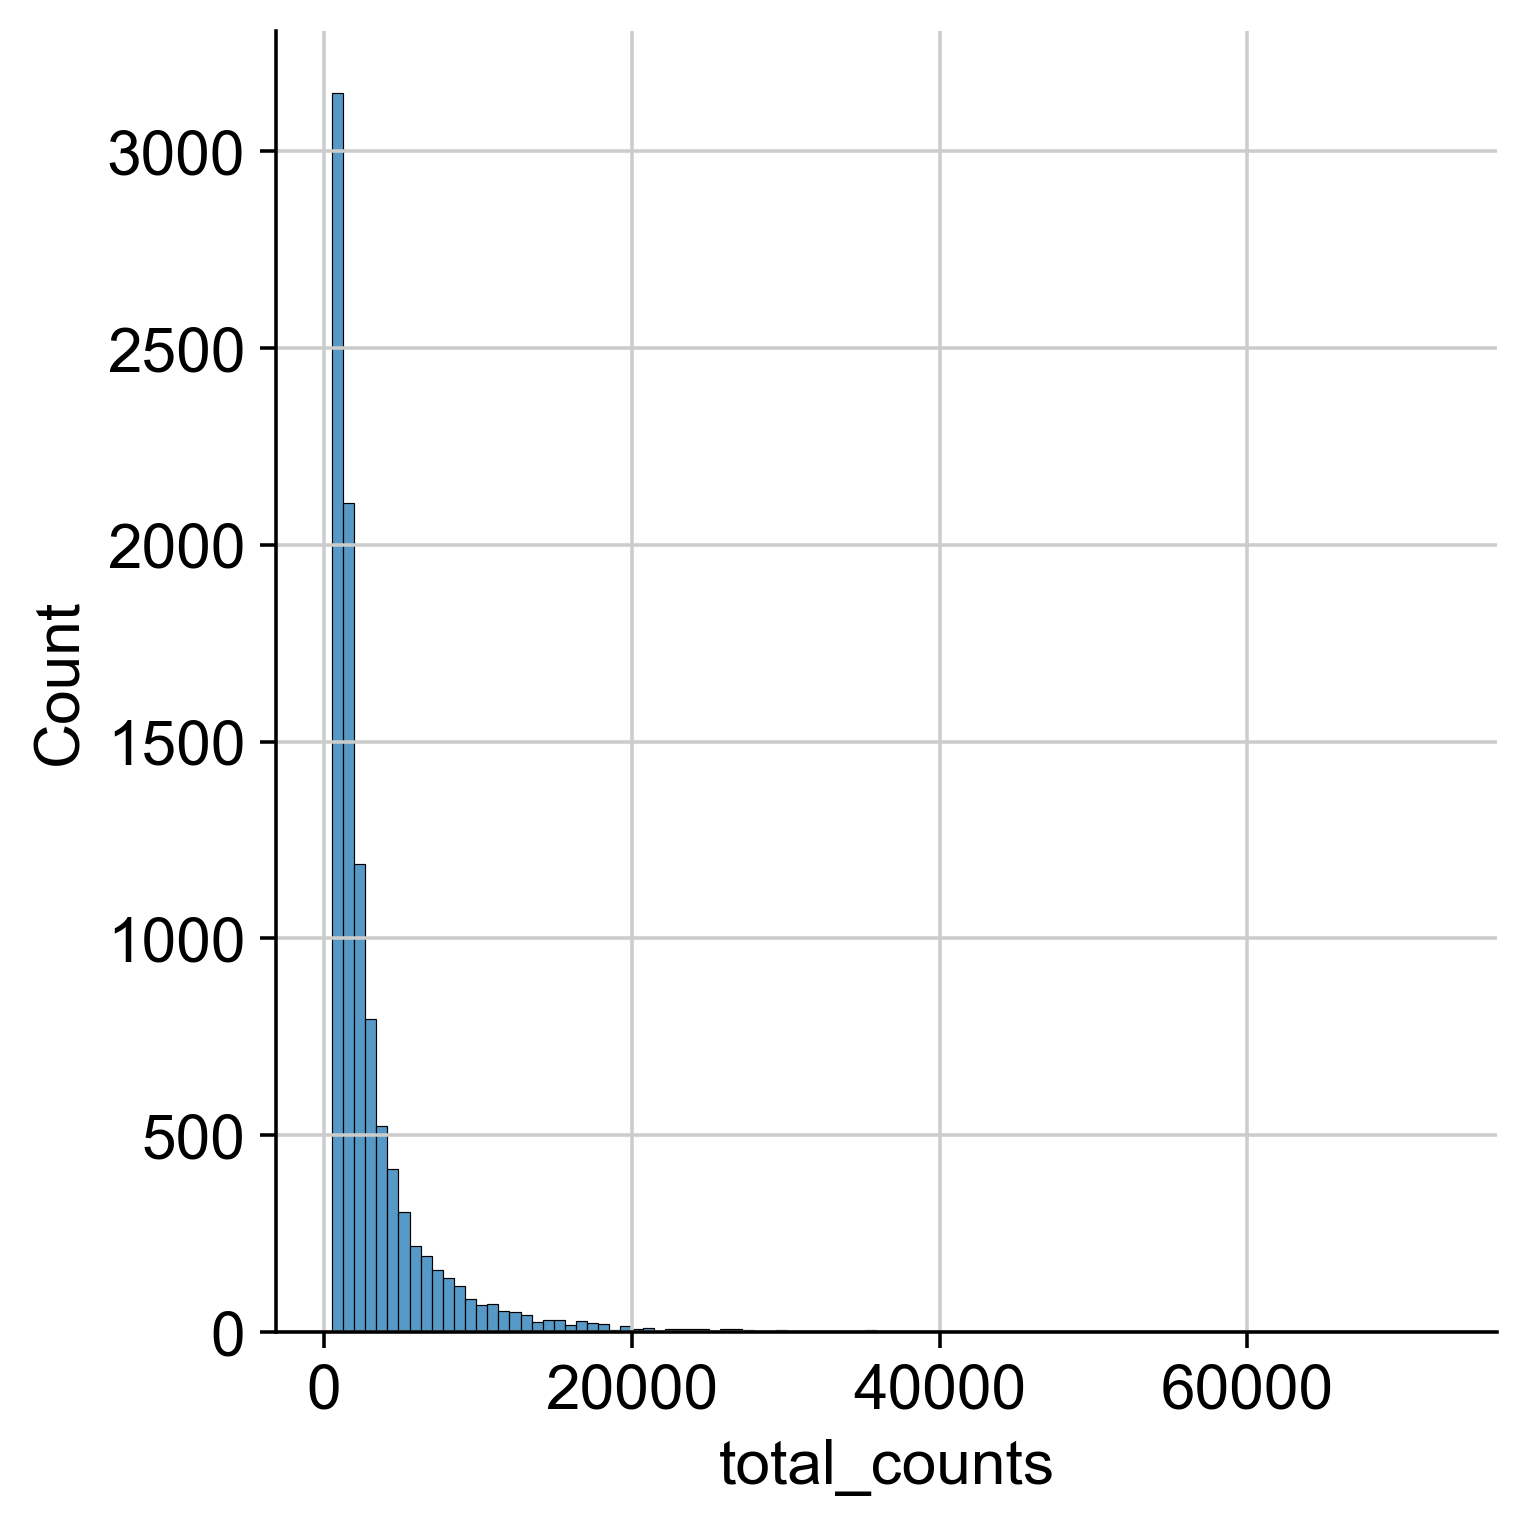

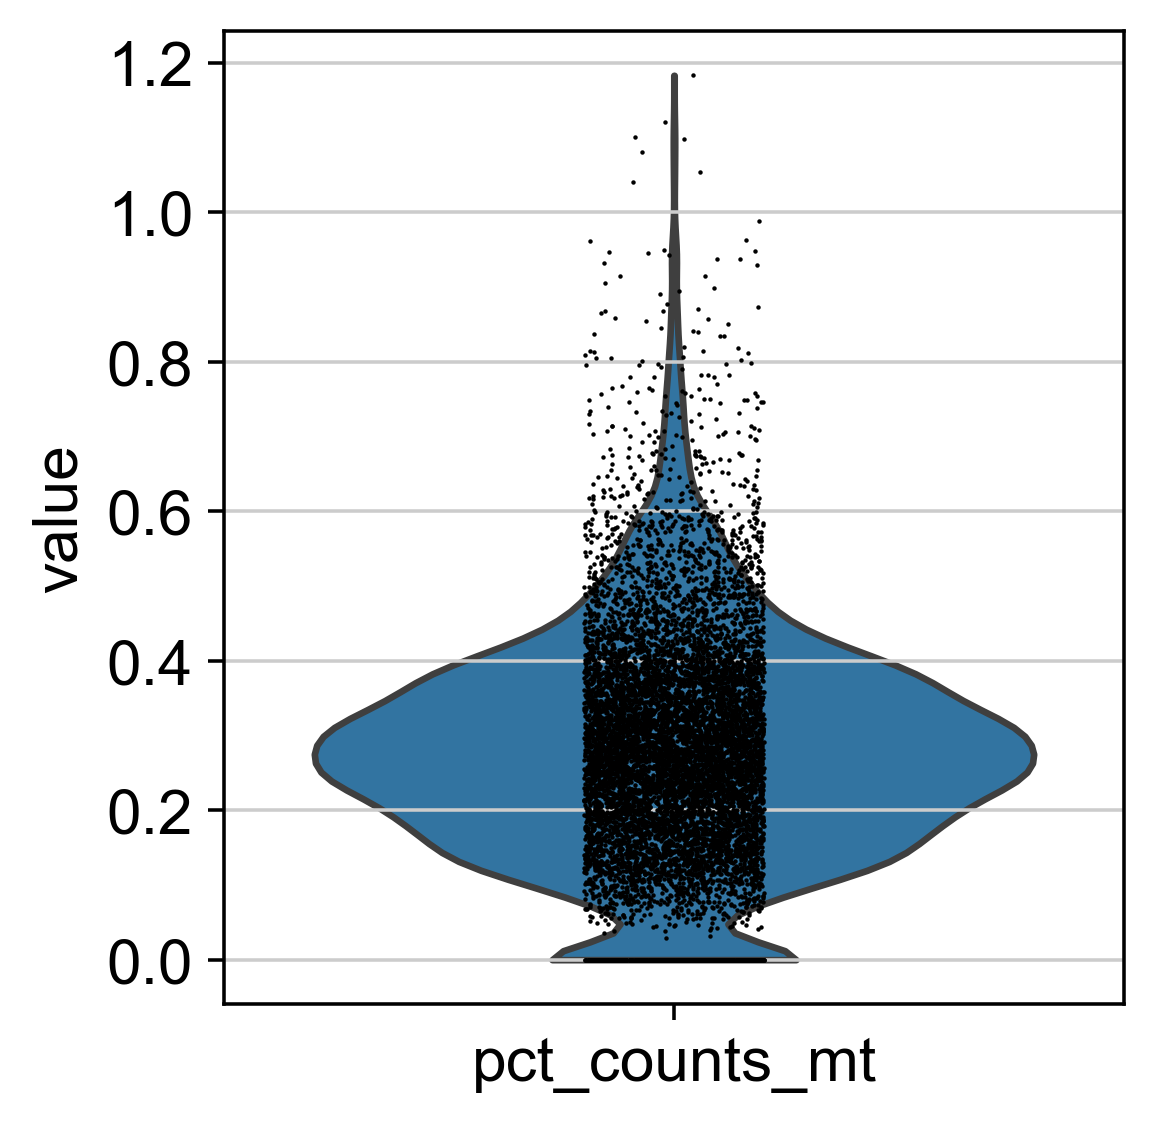

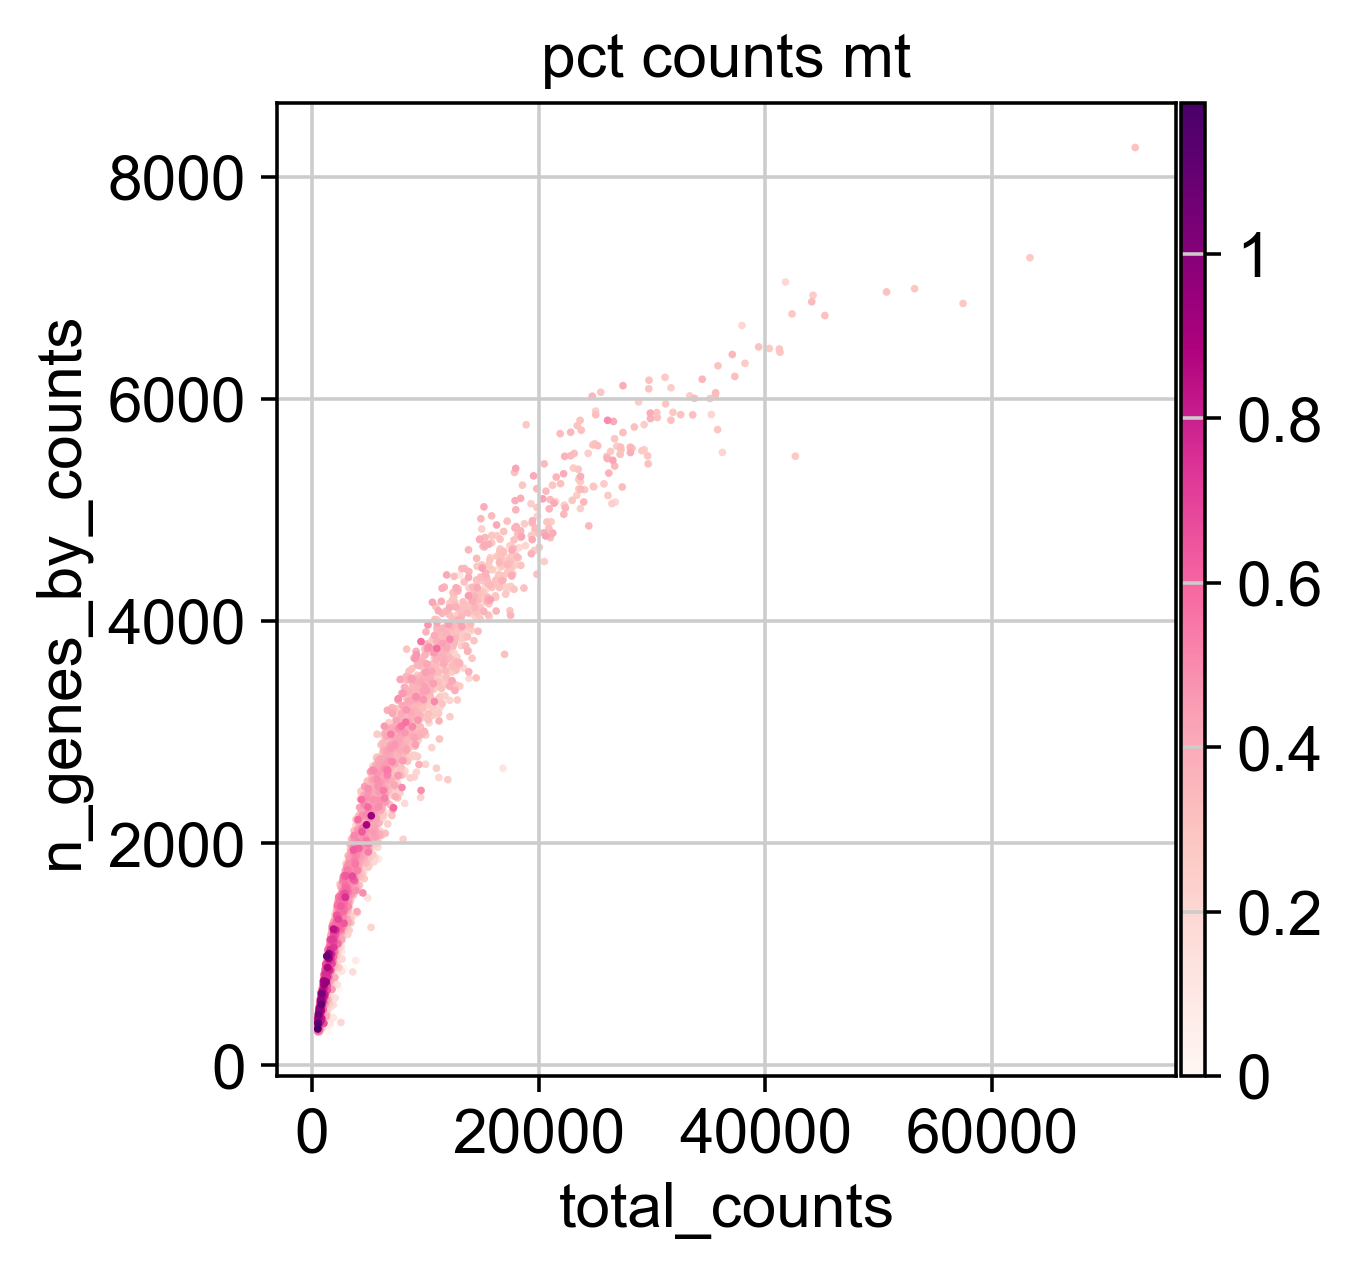

In [22]:
p1 = sns.displot(sample_object.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(sample_object, "pct_counts_mt")
p3 = sc.pl.scatter(sample_object, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

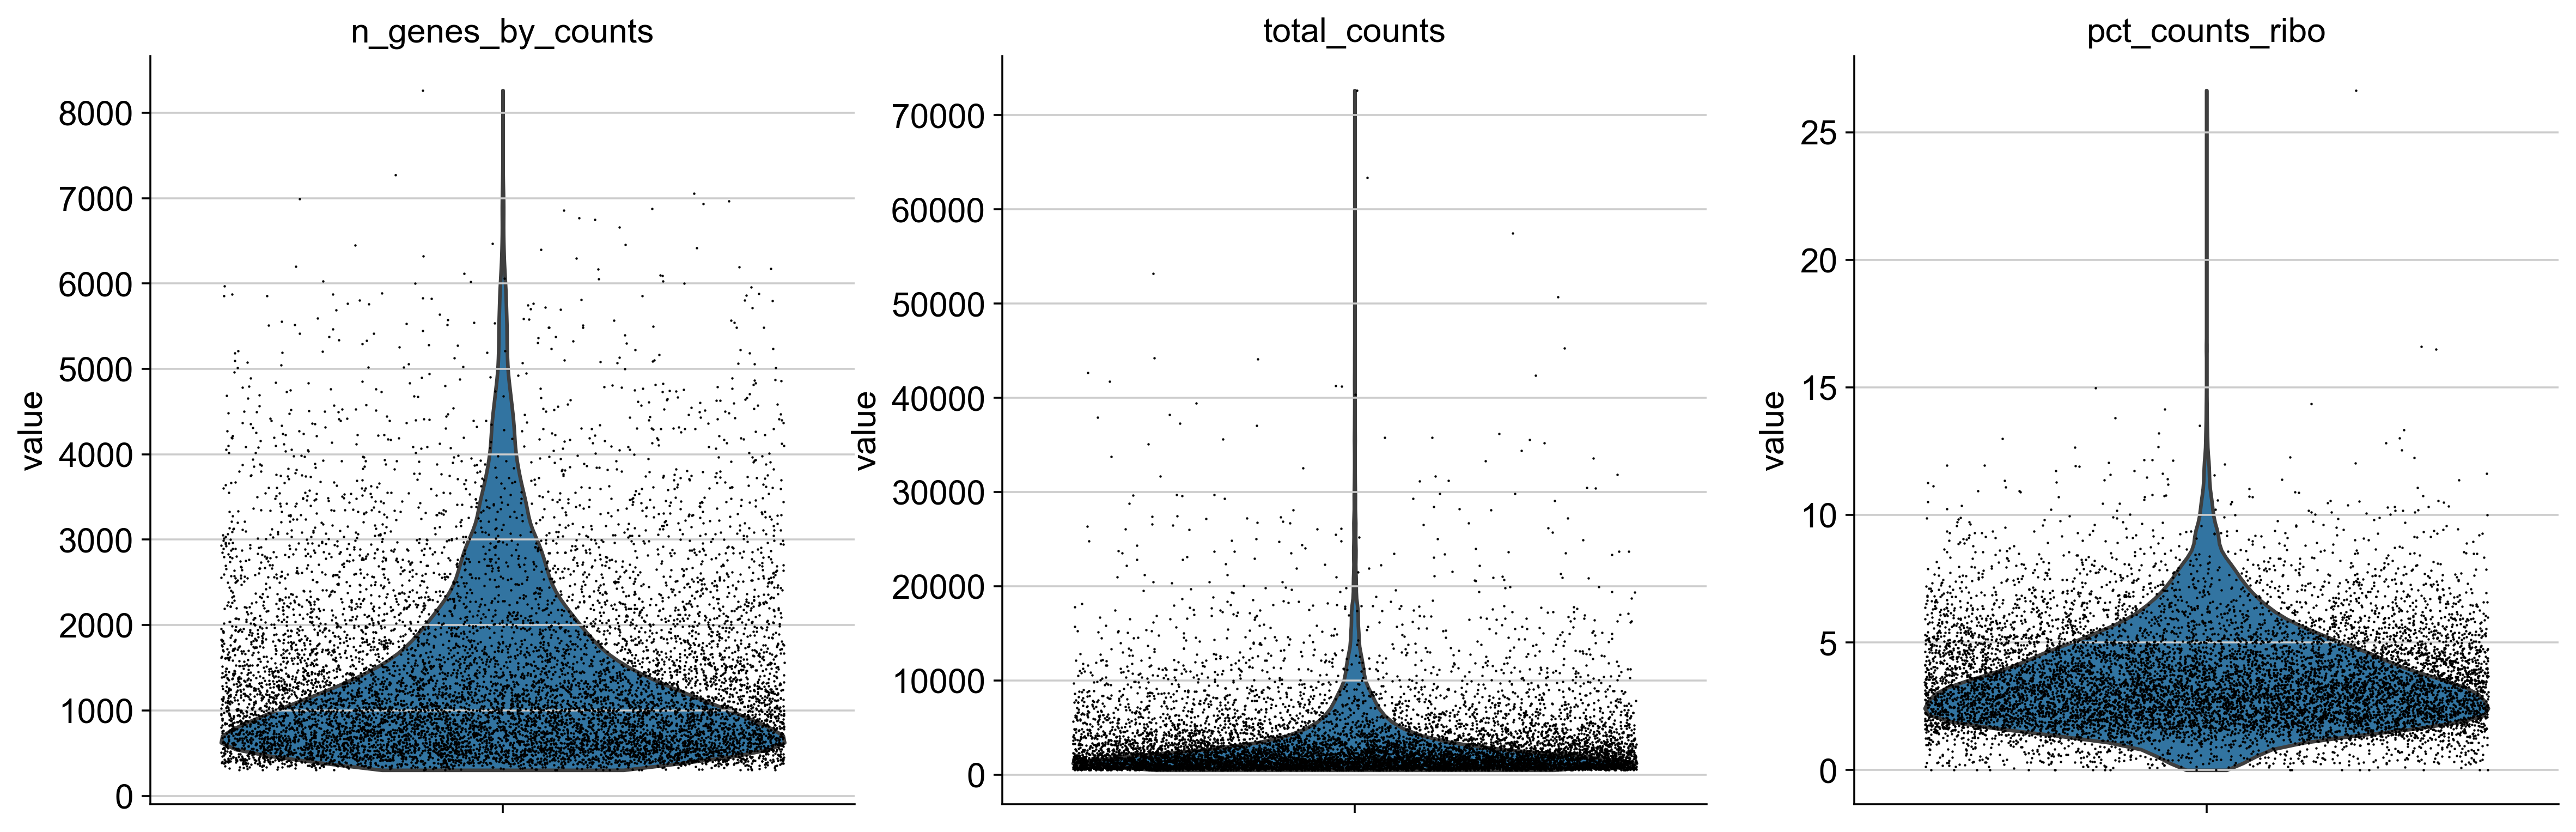

In [23]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

### QC-based filtering

In [24]:
sample_object.obs.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb
Array4_23118_TATTACCCCGCA,4583,4583,16699.0,52.0,0.311396,313.0,1.874364,1.0,0.005988
Array4_23118_CTCTTCCGCCTA,4321,4320,15943.0,47.0,0.294800,273.0,1.712350,1.0,0.006272
Array4_23118_CATGTCTCCTGC,4839,4829,14969.0,35.0,0.233817,372.0,2.485136,16.0,0.106888
Array4_23118_GTAACTCCCCGA,3922,3921,12294.0,39.0,0.317228,227.0,1.846429,2.0,0.016268
Array4_23118_CGCCGTCTGATC,4017,4015,12396.0,40.0,0.322685,187.0,1.508551,4.0,0.032268


In [25]:
sample_object.shape

(10006, 19942)

In [26]:
sample_object.obs["mt_ok"] = sample_object.obs['pct_counts_mt'] <= 20
sample_object.obs.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb,mt_ok
Array4_23118_TATTACCCCGCA,4583,4583,16699.0,52.0,0.311396,313.0,1.874364,1.0,0.005988,True
Array4_23118_CTCTTCCGCCTA,4321,4320,15943.0,47.0,0.294800,273.0,1.712350,1.0,0.006272,True
Array4_23118_CATGTCTCCTGC,4839,4829,14969.0,35.0,0.233817,372.0,2.485136,16.0,0.106888,True
Array4_23118_GTAACTCCCCGA,3922,3921,12294.0,39.0,0.317228,227.0,1.846429,2.0,0.016268,True
Array4_23118_CGCCGTCTGATC,4017,4015,12396.0,40.0,0.322685,187.0,1.508551,4.0,0.032268,True


In [27]:
sample_object.obs.mt_ok.value_counts()

mt_ok
True    10006
Name: count, dtype: int64

In [28]:
print(f"Total number of cells: {sample_object.n_obs}")
sample_object = sample_object[(sample_object.obs.mt_ok)].copy()

print(f"Number of cells after filtering of low quality cells: {sample_object.n_obs}")

Total number of cells: 10006
Number of cells after filtering of low quality cells: 10006


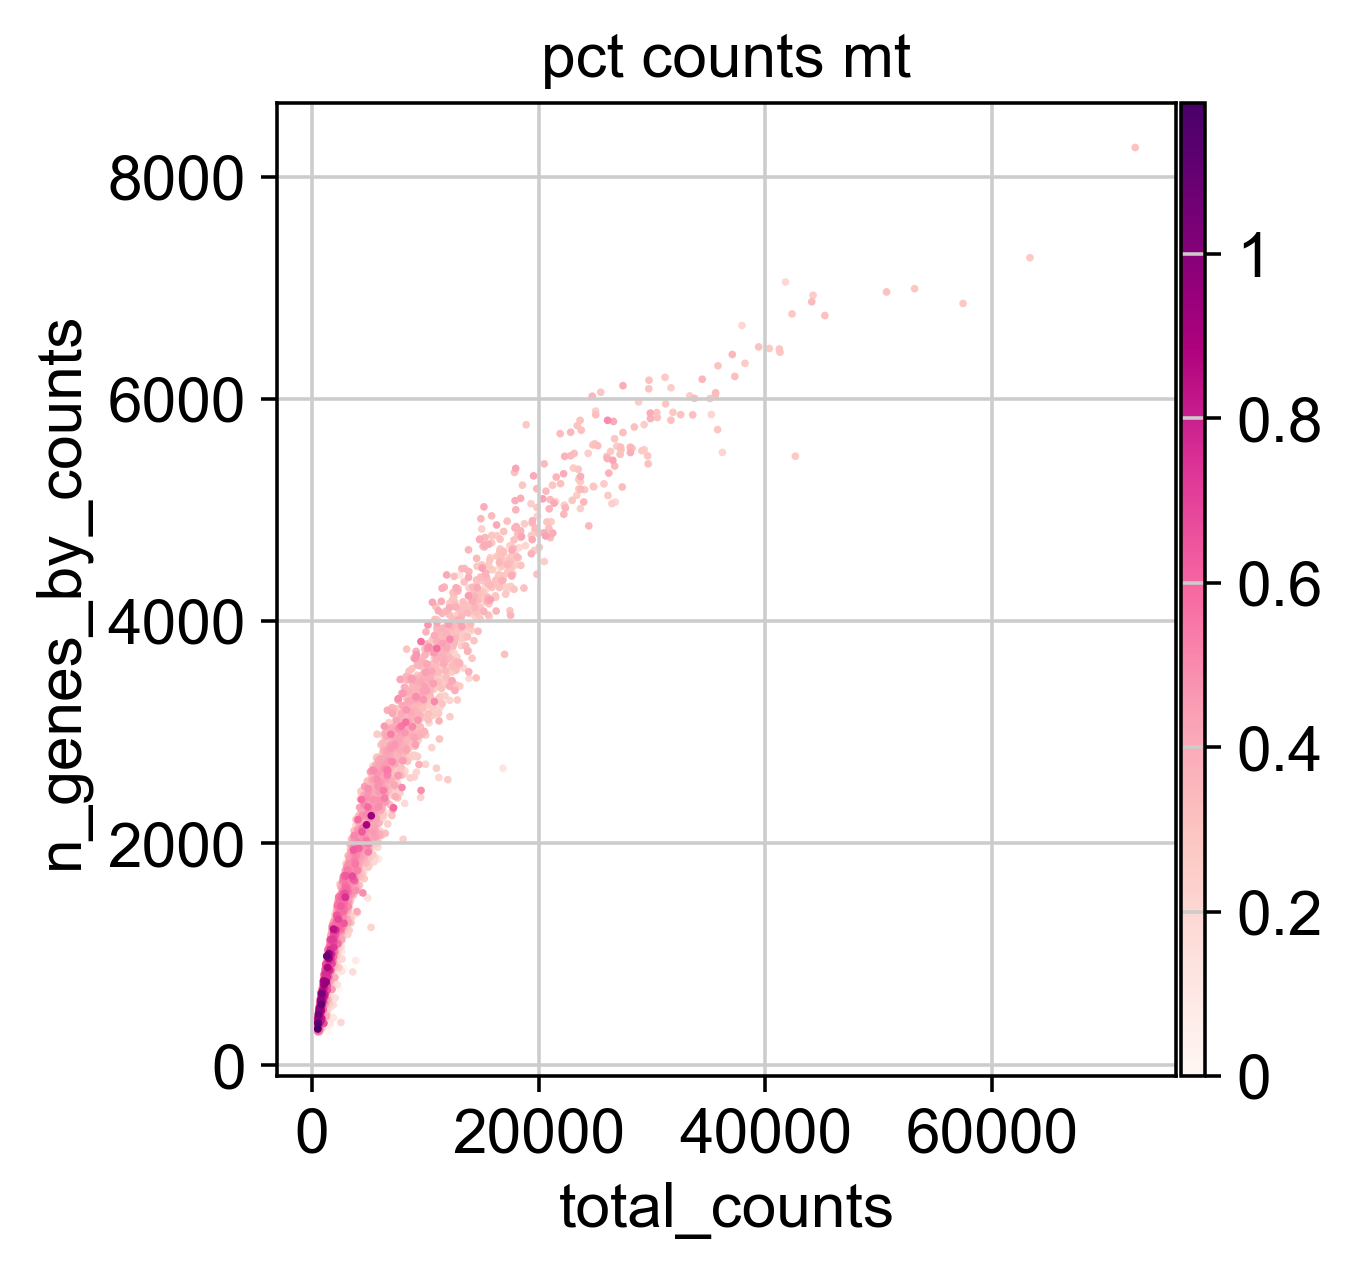

In [29]:
p1 = sc.pl.scatter(sample_object, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

### Sample sex covariate

In [30]:
annot = sc.queries.biomart_annotations(
        "mfascicularis",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("ensembl_gene_id")


In [31]:
annot.head()

,external_gene_name,start_position,end_position,chromosome_name
ensembl_gene_id,,,,
ENSMFAG00000055330,NaN,32222828,32225005,1
ENSMFAG00000052166,NaN,207191584,207193119,1
ENSMFAG00000048966,NaN,83610456,83611589,1
ENSMFAG00000056376,NaN,111229096,111230693,1
ENSMFAG00000063704,NaN,56043954,56045445,2


- Y chrom

In [32]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index([], dtype='object')

In [33]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1).A1 / np.sum(sample_object.X, axis = 1).A1 * 100

- X chromo

In [34]:
chrX_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "X"])
chrX_genes

Index([], dtype='object')

In [35]:
chrX_sum = sample_object[:, chrX_genes].X.sum(axis=1)
total_sum = sample_object.X.sum(axis=1)

# Flatten the arrays and calculate percent_chrY
sample_object.obs['percent_chrX'] = (np.asarray(chrX_sum).flatten() / np.asarray(total_sum).flatten()) * 100
sample_object.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb,mt_ok,percent_chrY,percent_chrX
Array4_23118_TATTACCCCGCA,4583,4583,16699.0,52.0,0.311396,313.0,1.874364,1.0,0.005988,True,0.0,0.0
Array4_23118_CTCTTCCGCCTA,4321,4320,15943.0,47.0,0.294800,273.0,1.712350,1.0,0.006272,True,0.0,0.0
Array4_23118_CATGTCTCCTGC,4839,4829,14969.0,35.0,0.233817,372.0,2.485136,16.0,0.106888,True,0.0,0.0
Array4_23118_GTAACTCCCCGA,3922,3921,12294.0,39.0,0.317228,227.0,1.846429,2.0,0.016268,True,0.0,0.0
Array4_23118_CGCCGTCTGATC,4017,4015,12396.0,40.0,0.322685,187.0,1.508551,4.0,0.032268,True,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Array6_24118_CGAATATTCCAA,337,337,525.0,0.0,0.000000,29.0,5.523809,0.0,0.000000,True,0.0,0.0
Array6_24118_TCTTGATCGCCC,354,354,511.0,1.0,0.195695,14.0,2.739726,0.0,0.000000,True,0.0,0.0
Array6_24118_CTACCCTGTCGT,331,331,513.0,1.0,0.194932,7.0,1.364522,0.0,0.000000,True,0.0,0.0
Array6_24118_CGTCGGCATCCT,323,323,509.0,0.0,0.000000,13.0,2.554028,0.0,0.000000,True,0.0,0.0


In [36]:
# Graph of samples with X chrom
sample_object.obs.percent_chrX.value_counts()

percent_chrX
0.0    10006
Name: count, dtype: int64

In [37]:
sample_object.obs.shape

(10006, 12)

In [41]:
sample_object.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb,mt_ok,percent_chrY,percent_chrX
Array4_23118_TATTACCCCGCA,4583,4583,16699.0,52.0,0.311396,313.0,1.874364,1.0,0.005988,True,0.0,0.0
Array4_23118_CTCTTCCGCCTA,4321,4320,15943.0,47.0,0.294800,273.0,1.712350,1.0,0.006272,True,0.0,0.0
Array4_23118_CATGTCTCCTGC,4839,4829,14969.0,35.0,0.233817,372.0,2.485136,16.0,0.106888,True,0.0,0.0
Array4_23118_GTAACTCCCCGA,3922,3921,12294.0,39.0,0.317228,227.0,1.846429,2.0,0.016268,True,0.0,0.0
Array4_23118_CGCCGTCTGATC,4017,4015,12396.0,40.0,0.322685,187.0,1.508551,4.0,0.032268,True,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Array6_24118_CGAATATTCCAA,337,337,525.0,0.0,0.000000,29.0,5.523809,0.0,0.000000,True,0.0,0.0
Array6_24118_TCTTGATCGCCC,354,354,511.0,1.0,0.195695,14.0,2.739726,0.0,0.000000,True,0.0,0.0
Array6_24118_CTACCCTGTCGT,331,331,513.0,1.0,0.194932,7.0,1.364522,0.0,0.000000,True,0.0,0.0
Array6_24118_CGTCGGCATCCT,323,323,509.0,0.0,0.000000,13.0,2.554028,0.0,0.000000,True,0.0,0.0


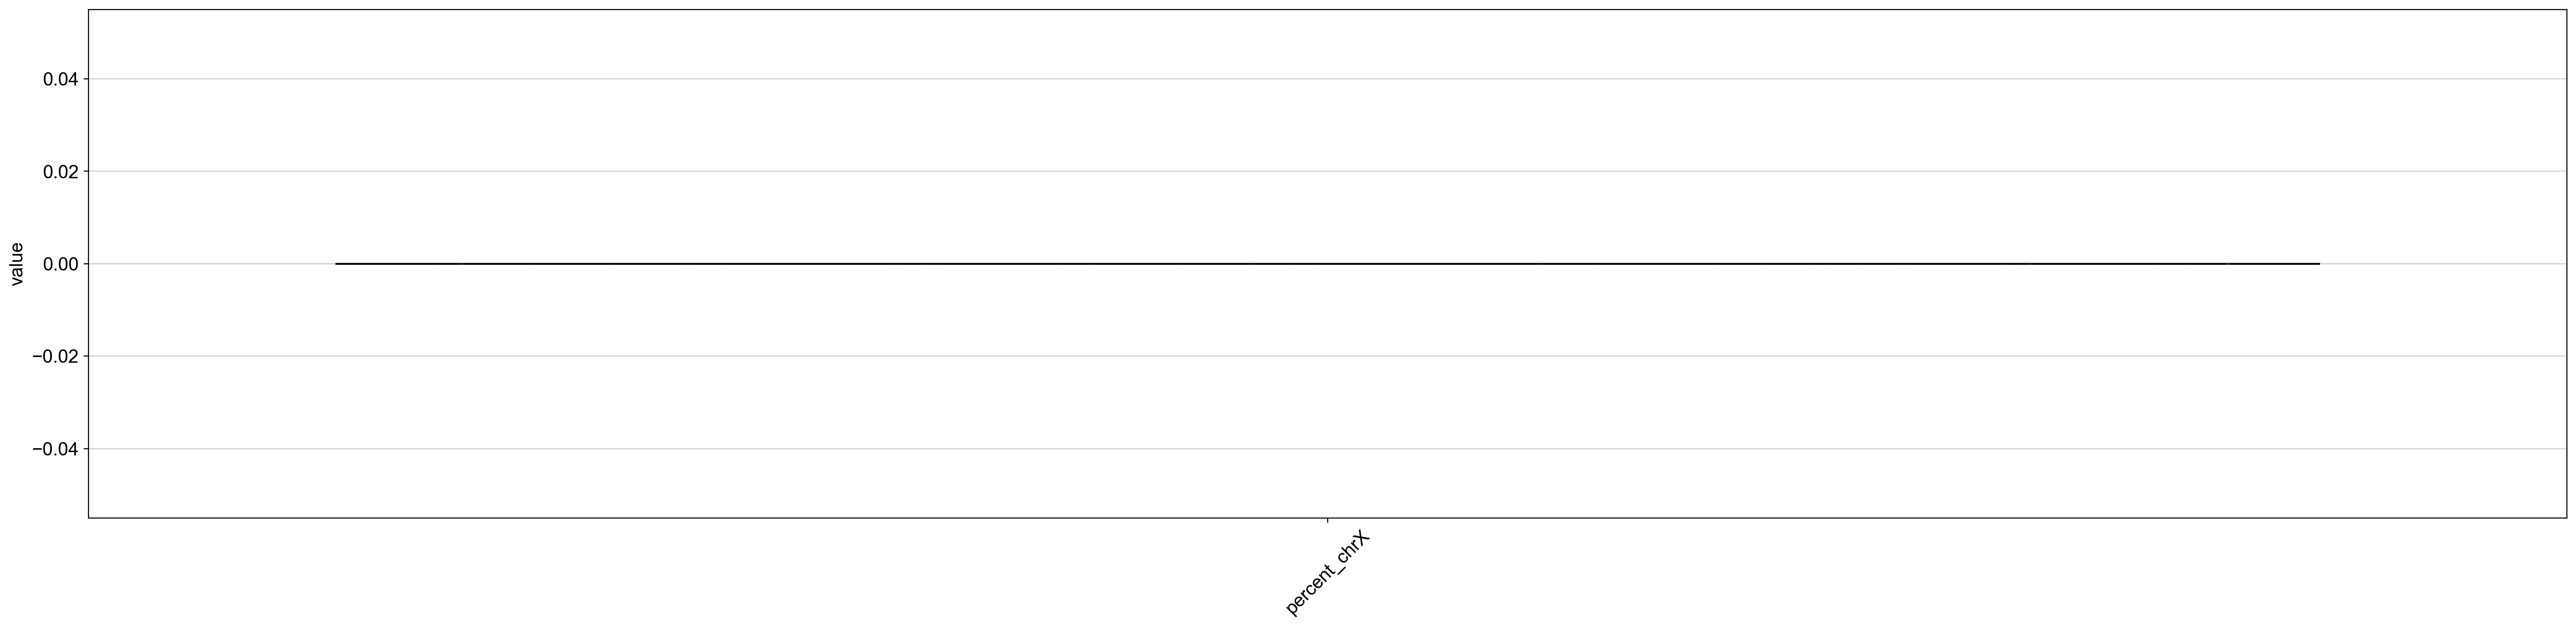

In [42]:
sc.set_figure_params(figsize=(25, 7),dpi=100)
sc.pl.violin(sample_object, ["percent_chrX"], jitter = 0.4, rotation = 45)

### Cell cycle scores

In [43]:
!if [ ! -f /Users/mairi.mcclean/data/qc_files/mfasc_orthog_cell_cycle_genes.txt ]; then curl -o /Users/mairi.mcclean/data/qc_files/mfasc_orthog_cell_cycle_genes.txt https://raw.githubusercontent.com/Talavera-Lopez-Lab/Mairi-PhD/main/sc_temp_folder/cell_cycle_genes/mfasc_orthog_cell_cycle_genes.txt?token=GHSAT0AAAAAACBVCJYZCXEBCEQZZKWQJC22ZD7AUZA

zsh:1: parse error near `https://raw.githubus...'


In [44]:
cell_cycle_genes = [x.strip() for x in open('/Users/mairi.mcclean/data/qc_files/mfasc_orthog_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
g2m_genes = cell_cycle_genes[:46]
s_genes = cell_cycle_genes[46:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

88
87


In [45]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['APOE', 'BPIFB1', 'CD74', 'COL3A1', 'CTSB', 'CXCL8', 'DCN', 'FN1', 'GNLY', 'GZMB', 'HBB', 'HSP90B1', 'HSPA5', 'IFIT2', 'JCHAIN', 'LOC102116308', 'LOC102119798', 'LOC102128706', 'LOC102133296', 'LOC102141751', 'LOC102142558', 'LOC102144039', 'LOC102147203', 'LOC107126411', 'LYZ', 'OLFM4', 'PLEK', 'rna76576', 'rna76578', 'SCGB1A1', 'SCGB3A1', 'SERPINA3', 'SFTPB', 'SFTPC', 'SOD2', 'VMO1']
    finished (0:00:00)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    585 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    626 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


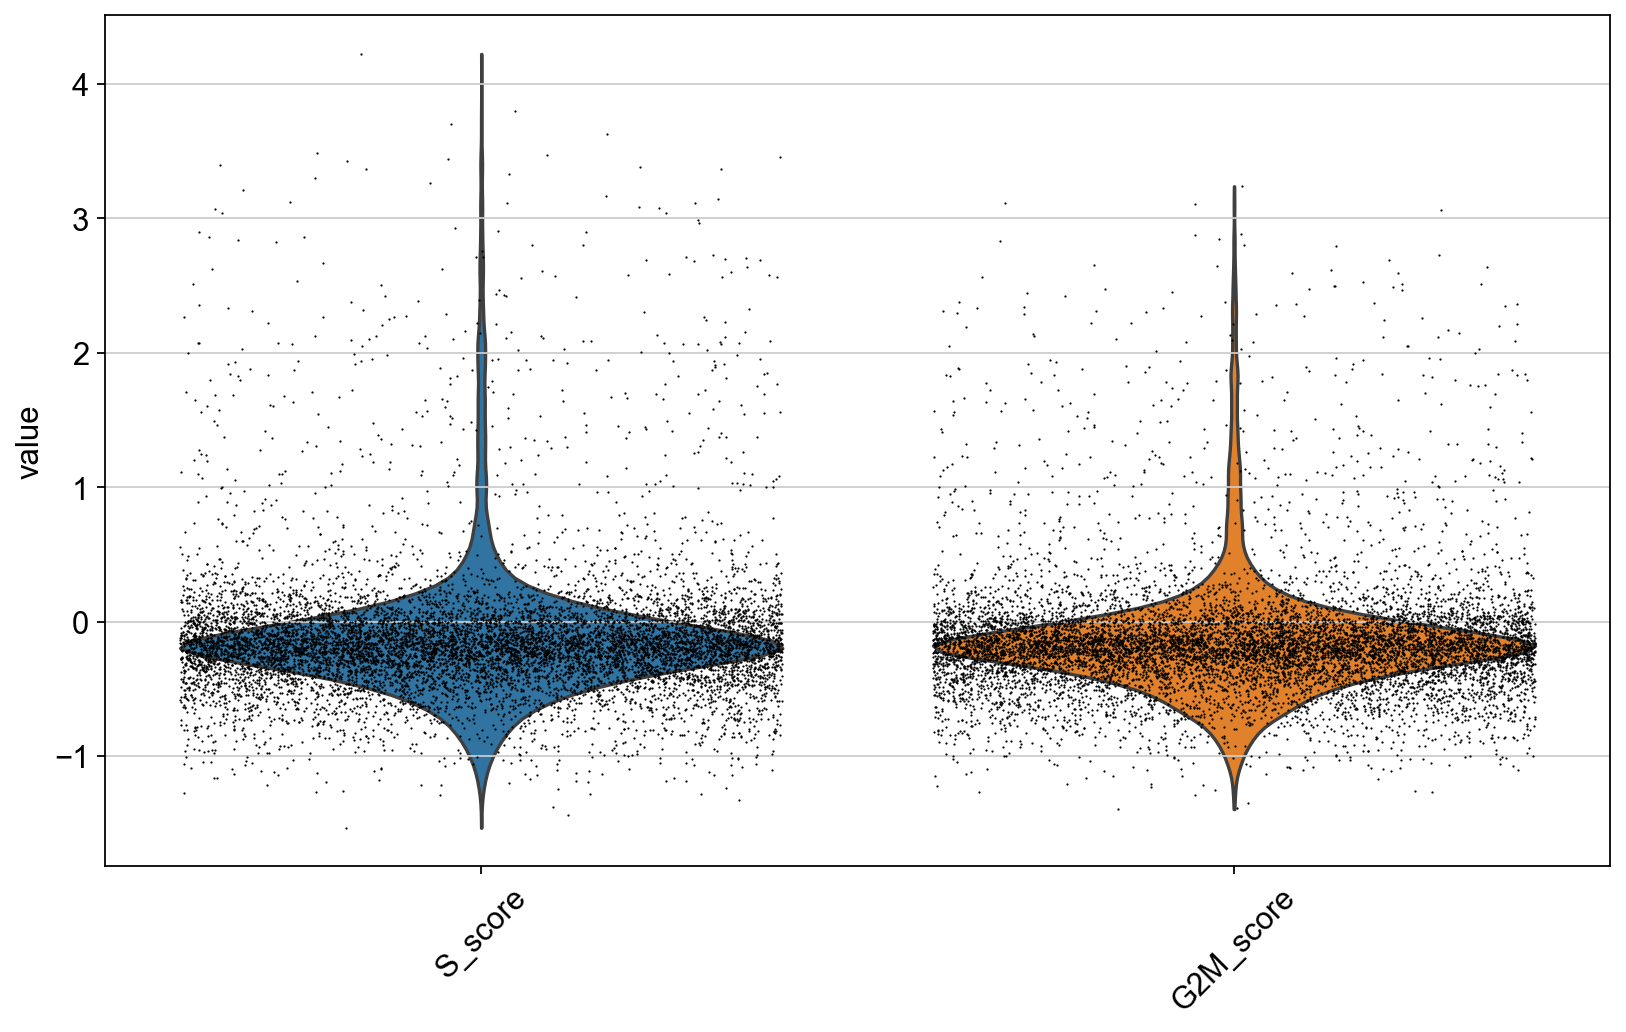

In [47]:
# Set specific figure params

sc.set_figure_params(figsize=(10, 7))
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(adata_log, ['S_score', 'G2M_score'],
             jitter = 0.4, rotation = 45)

In [48]:
sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object

AnnData object with n_obs × n_vars = 10006 × 19942
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'mt_ok', 'percent_chrY', 'percent_chrX', 'S_score', 'G2M_score'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Predict doublets

In [49]:
import scrublet

In [50]:
scrub = scrublet.Scrublet(sample_object.X)

In [51]:
sample_object.obs['doublet_scores'], sample_object.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

Preprocessing...


/Users/mairi.mcclean/mambaforge/envs/new_scanpy_local/lib/python3.9/site-packages/scrublet/helper_functions.py:254: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 3.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.9%
Elapsed time: 6.6 seconds


(<Figure size 640x240 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

In [52]:
sum(sample_object.obs['predicted_doublets'])

23

In [54]:
# Re-set figure params
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

# Plot doublet detection results
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'predicted_doublets'],
             jitter = 0.2, rotation = 45, multi_panel=False)

TypeError: can't get common type for non-numeric array

### Prepare counts for individual slots

In [55]:
sample_object.raw = sample_object.copy()
sample_object.layers['counts'] = sample_object.X.copy()
sample_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object, inplace = False)["X"]
)
sample_object

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 10006 × 19942
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'mt_ok', 'percent_chrY', 'percent_chrX', 'S_score', 'G2M_score', 'doublet_scores', 'predicted_doublets'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts', 'sqrt_norm'

### Export object

In [56]:
sample_object.write('/Volumes/Expansion/data_lake/processed_files/qc_objects/nhp/gideon2021/Gideon2021_wk4_scrna_granhomog_mm_221209_qcd.h5ad')